<img src="./auxdata/eurac_EO.png" alt="EURAC Institute for Earth Observation" title="EURAC Institute for Earth Observation" width="300"/>

In this notebook we will use openEO to retrieve a timeseries of cloud free Sentinel-2 data given a point with it's coordinates.

In [1]:
import openeo
from openeo.processes import eq, array_element
import xarray as xr

Connect to the EURAC openEO back-end

In [2]:
euracEndpoint = "https://openeo.eurac.edu"
conn = openeo.connect(euracEndpoint).authenticate_oidc(client_id="openEO_PKCE")

Authenticated using refresh token.


Set the temporal extent we want to consider

In [3]:
temporal_extent = ["2018-01-01","2019-01-01"]

Set the point coordinates

In [5]:
point_coords = [46.487317942782414, 11.249706840515137]

Set the spatial extent to use in load_collection: we apply a little buffer to the point coordinates.

In [6]:
spatial_extent = {'west':point_coords[1],'east':point_coords[1],'north':point_coords[0],'south':point_coords[0]}

Set the collection name for the Sentinel-2 data

In [7]:
S2_collection = 'S2_L2A_ALPS'

Set the bands we want to load

In [13]:
bands = ['B02','B03','B04','CLOUD_MASK']

Load the S2 data:

In [14]:
S2_data = conn.load_collection(S2_collection,temporal_extent=temporal_extent,spatial_extent=spatial_extent,bands=bands)

We need to mask out the cloudy pixels. We can use the CLOUD_MASK layer for this:

In [15]:
cloud_mask = S2_data.filter_bands('CLOUD_MASK').reduce_dimension(dimension="bands",reducer = lambda value: eq(array_element(value,0),1))

Apply the mask to the S2 data

In [17]:
S2_data_masked = S2_data.filter_bands(['B02','B03','B04']).mask(cloud_mask,replacement=0)

Download the result

In [18]:
S2_data_masked.download('S2_data_masked.nc')

Open the result

In [19]:
data = xr.open_dataarray('S2_data_masked.nc')
data

<xarray.DataArray (variable: 3, time: 92, y: 1, x: 1)>
array([[[[8674.]],

        ...,

        [[   0.]]],


       ...,


       [[[8795.]],

        ...,

        [[   0.]]]])
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T10:24:20.462000 ... 2018-12...
  * y            (y) float64 5.151e+06
  * x            (x) float64 6.727e+05
    spatial_ref  int32 ...
  * variable     (variable) object 'B02' 'B03' 'B04'
Attributes:
    crs:           EPSG:32632
    grid_mapping:  spatial_ref

There are many different ways of visualizing the results. Some examples can be found here for XArray: https://xarray-contrib.github.io/xarray-tutorial/scipy-tutorial/04_plotting_and_visualization.html

See also the Matplotlib documentation https://matplotlib.org

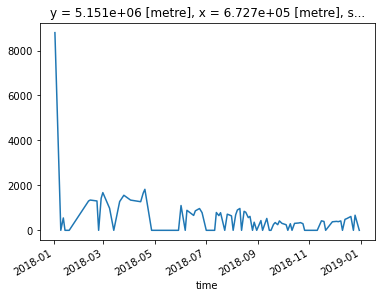

In [20]:
B04 = data.loc[dict(variable='B04')]
B04.plot()

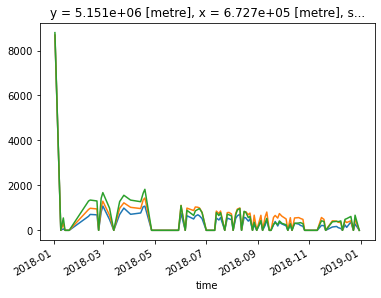

In [25]:
data.loc[dict(variable='B02')].plot()
data.loc[dict(variable='B03')].plot()
data.loc[dict(variable='B04')].plot()

If the data is still noisy, probably the clouds did not get fully filtered out. We can try to "clean" the signal by manually setting a threshold:

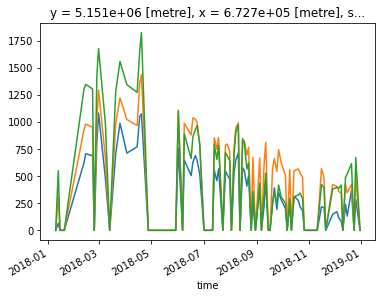

In [28]:
th = 4000
data.where(data<th).loc[dict(variable='B02')].plot()
data.where(data<th).loc[dict(variable='B03')].plot()
data.where(data<th).loc[dict(variable='B04')].plot()